# Climb Dataset

Rock climbing is a popular sport that involves participants scaling natural rock formations or artifical rock walls. Each formation has a rated difficulty, and participants may push themselves to complete climbs of increasing difficulty.

In this project, we intend to train regression models that are able to predict the maximum grade (maximum difficulty) successfully scaled by a rock climber based on various variables.

## Table of Contents
* [Data Acquisition](#data-acquisition)
* [Problem Formulation](#problem-statement)
* [Exploratory Analysis & Data Cleaning](#exploratory-analysis-and-data-cleaning)
* [Machine Learning](#machine-learning)
    * [Linear Regression](#linear-regression)
    * [Support Vector Machines (SVM)](#support-vector-machines)
    * [K Nearest Neighbours (KNN)](#k-nearest-neighbours)
* [Conclusions](#conclusions)
* [Considerations](#considerations)

In [1]:
#Import libs
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sb
import sys
import matplotlib.pyplot as plt # data visualization
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
%%script false --no-raise-error

# Cell for Colaboratory init
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

climber_id = "1pwhxhHNFi8cueSq9C3TkzC0yJ_AqeqEz"
grades_id  = "1pZoq43V79U6GFUcNqp5cJyr0LtxQ0M3o"

downloaded = drive.CreateFile({'id':climber_id}) 
downloaded.GetContentFile('climber_df.csv')
downloaded = drive.CreateFile({'id':grades_id}) 
downloaded.GetContentFile('grades_conversion_table.csv')  

## Data Acquisition
The dataset we will be using for this project is the <a href="https://www.kaggle.com/datasets/jordizar/climb-dataset" target="_blank">Climb Dataset</a> provided by Jordi Zaragoza which provides us with data from individual rock climbers across multiple countries and age groups.

The main dataset, `climber_df.csv` provides us with 10927 rows and 16 columns of data:

|Column|user_id|country|sex|height|weight|age|years_cl|date_first|year_first|grades_first|date_last|year_last|grades_last|grades_count|grades_mean|grades_max| 
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-
Type|-| Categorical |Categorical |Numerical  |Numerical  |Numerical  |Numerical  |Date       |Numerical  |Numerical  |Date       |Numerical  |Numerical  |Numerical  |Numerical  |Numerical  
Description|-|Country of the user |Biological sex |Height in cm |Weight in kg |Age (in integer years) |"Years climbing" |Date of first recorded climb |Integer year of first recorded climb |Grade of first recorded climb |Date of last recorded climb |Integer year of last recorded climb |Grade of last recorded climb |Number of reported grades |Mean grade of recorded climbs |Highest grade of recorded climbs

## Importing Dataset <a class="anchor" id="importing-dataset"></a>
First, we import the necessary files

**climber_df.csv** - Raw data of the climbers  
**grades_conversion_table.csv** - Lookup table for climbing grades

In [3]:
# Import data
climber_df = pd.read_csv("climber_df.csv")
grades_raw = pd.read_csv("grades_conversion_table.csv")

# Create clean dataset, and track the cleaning status
dataset_raw = climber_df.copy()
status = set()

#Making a new dataset to keep track of cleaned dataset
dataset_cleaned = dataset_raw.copy()

display(dataset_raw, grades_raw)

user_id country  sex  height  weight   age  years_cl  \
0            1     SWE    0     177      73  41.0        21   
1            3     SWE    0     180      78  44.0        22   
2            4     SWE    1     165      58  33.0        16   
3           10     SWE    0     167      63  52.0        25   
4           16     NOR    0     177      68  44.0        21   
...        ...     ...  ...     ...     ...   ...       ...   
10922    66987     ESP    0     194      83  33.0         5   
10923    66988     USA    0     183      78  22.0         1   
10924    67009   other    0     165      63  41.0        20   
10925    67019     NOR    0     172      73  26.0         4   
10926    67020     DEU    0     178      78  24.0        12   

                date_first            date_last  grades_count  grades_first  \
0      1999-02-06 23:00:00  2001-07-31 22:00:00            84            36   
1      1999-03-31 22:00:00  2000-07-19 22:00:00            12            53   
2      2004-06-30 22:00:00  2009-05-26 22:00:00           119            53   
3      2000-01-14 23:00:00  2017-06-01 22:00:00           298            53   
4      1998-02-27 23:00:00  2010-05-13 22:00:00             5            53   
...                    ...                  ...           ...           ...   
10922  2015-05-01 22:00:00  2017-09-03 22:00:00            27            35   
10923  2017-09-03 22:00:00  2017-09-06 22:00:00             2            33   
10924  2017-09-09 22:00:00  2003-06-19 22:00:00            35            53   
10925  2017-06-14 22:00:00  2017-08-11 22:00:00             7            44   
10926  2017-03-03 23:00:00  2017-07-14 22:00:00            10            33   

       grades_last  grades_max  grades_mean  year_first  year_last  
0               55          62    46.750000        1999       2001  
1               51          59    52.833333        1999       2000  
2               49          64    53.890756        2004       2009  
3               49          63    49.406040        2000       2017  
4               49          53    51.400000        1998       2010  
...            ...         ...          ...         ...        ...  
10922           44          49    39.666667        2015       2017  
10923           28          33    30.500000        2017       2017  
10924           46          59    45.800000        2017       2003  
10925           46          46    42.714286        2017       2017  
10926           36          55    41.500000        2017       2017  

[10927 rows x 16 columns]

Unnamed: 0  grade_id grade_fra
0            0         0         -
1            1         1         -
2            2         2         -
3            3         3         1
4            4         4        1a
..         ...       ...       ...
80          80        80    9b+/9c
81          81        81        9c
82          82        82      9c/+
83          83        83       9c+
84          84        84   9c+/10a

[85 rows x 3 columns]

### Grade Description
There are 2 main conventions for rating climb difficulty, the Fontainebleau Scale and the V-scale.

|grade_id|Fontainebleau Scale|V-scale|
|-|-|-
|3|1|-
|13|3|VB (Basic)
|29|5|V1
|77|9b|V17

Notably, grade values are sorted based on difficulty, hence we are able to perform scalar predictions on variables that are mapped to `grade_id`.

## Problem Statement

<h4 style="text-align:center;"> Given the <ins>initial state</ins> of a rock climber, we wish to predict the <ins>highest difficulty</ins> that they will achieve in <ins>the future</ins>.</h4>

<br> 

* **Initial State (Predictor)**

    This "initial state" includes variables known at the time of prediction. **Assuming a climber has already completed his first climb**, we have:

    ```
    date_first, year_first, grade_first, country, sex, height, weight, age
    ```
    > As a secondary goal, we also aim to generalise this initial state such that it is applicable to as many rock climbers as possible.

* **Future State (Predictor)**  

    We define a future state based on:
    * Number of climbs done since the initial state, `grades_count`
    * Years since the first climb, `years_cl`
    * Years spent actively climbing, `date_last` and `year_last`  
<br>

    ```
    grades_count, years_cl, date_last, year_last
    ```

<br>

* **Highest difficulty (Response)**
    
    Our response variable is represented by `grades_max` which represents the highest-graded climb completed, and  can be treated as a scalar variable.

<br>

## Exploratory Analysis and Data Cleaning
In this section, we perform exploratory analysis on key variables and create new variables to represent combinations of related features.

* [Initial Correlation](#initial-correlation)
* [Grades](#grades)
* [Country](#country)
* [Height and Weight](#height-and-weight)
* [Climbing Durations](#climbing-durations)
* [Age](#age)
* [Outliers](#Outliers)
* [Final Correlation](#final-correlation)



### Initial Correlation

A preliminary check of the correlations between values of the dataset results in the following heatmap:

<AxesSubplot: >

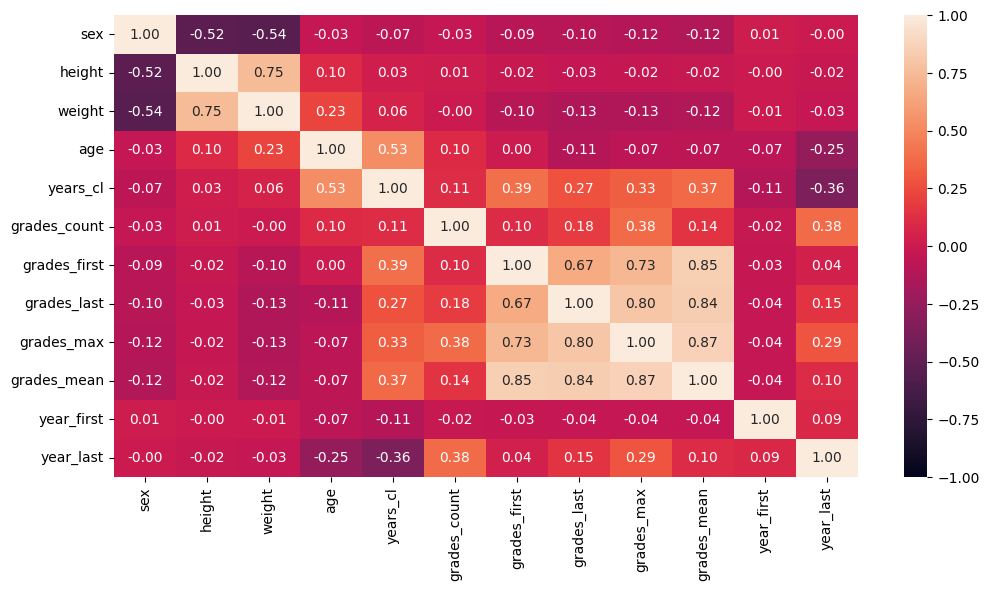

In [4]:
dataset_cleaned_corr = pd.DataFrame(dataset_raw[["sex", "height", "weight", "age", "years_cl", "grades_count", "grades_first", "grades_last", "grades_max", "grades_mean", "year_first", "year_last"]])

fig, ax = plt.subplots(figsize=(12,6)) 
sb.heatmap(dataset_cleaned_corr.corr(), vmin = -1, vmax = 1, annot=True, fmt = ".2f")

We observe a few expected correlations:
* `height` and `weight` are closely correlated, and gender is inversely correlated to both due to females being generally shorter and lighter than males
* `age` and `years_cl` are directly correlated, since years spent climbing is upper bounded by the age of the individual  
* It is also interesting to note that `grades_first` is highly correlated to `grades_max`. This could be due several reasons:
    * Having a higher first grade is a strong indicator of confidence and one is thus likely to attempt climbs of higher difficulty
    * Some individuals could have climbed very few times, thus their first grade climbed is equal or close to their maximum grade achieved.

The correlation between `grades_max` and our other discussed variables is generally low, and they must be improved to achieve useful results.

### Grades

Our dataset provides 5 main grade variables:
* `grades_count`
* `grades_first`
* `grades_last`
* `grades_mean`
* `grades_max`, our response variable

It would be unfair to include `grades_mean` and `grades_last` into our predictor variables as **these variables are not known at the time of prediction**, which assumes that a climber has only completed their first climb.

<br>

In [5]:
grades = dataset_cleaned[["grades_max", "grades_first", "grades_last", "grades_mean"]]

In [6]:
grades['grades_max'].describe()

count    10927.000000
mean        53.764437
std          9.679533
min         29.000000
25%         46.000000
50%         55.000000
75%         62.000000
max         77.000000
Name: grades_max, dtype: float64

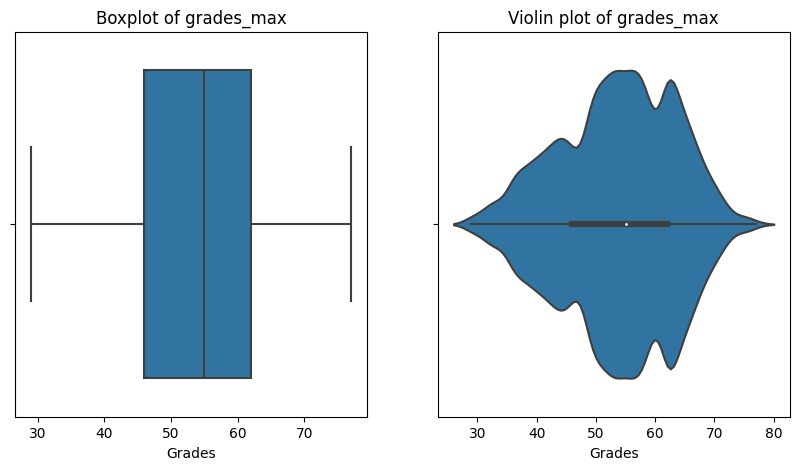

In [7]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create a horizontal boxplot of grades_max
sb.boxplot(x=grades['grades_max'], ax=axs[0], orient='horizontal')
axs[0].set_title('Boxplot of grades_max')
axs[0].set_xlabel('Grades')

# Create a horizontal violin plot of grades_max in the second subplot
sb.violinplot(x=grades['grades_max'], ax=axs[1], orient='h')
axs[1].set_title('Violin plot of grades_max')
axs[1].set_xlabel('Grades')

# Show the plot
plt.show()

We also find that `grades_max` is relatively well distributed and generally follows a normal distribution:
1. The lowest grade has a `grade_id` of 29, which is a difficulty of 5 on the Fontainebleau Scale, which translates to a relatively easy climb for beginners.

3. The average grade has a `grade_id` of 56, which is a difficulty of 7b+/7c on the Fontainebleau Scale and translates to a challenging climb, even for avid climbers

2. The highest grade has a `grade_id` of 77, which is a 9b on the Fontainebleau Scale and well within the difficulty range of professional climbers

### Country
First, we observe that:
1. Data for this column is categorical and is stored as 26 unique unordered 3-character strings (eg. ESP, POL)
2. Most data is collected from Europe
3. There is a substantial difference in median, upper and lower quartiles of `grades_max` between countries in which could be useful
4. Grouping data by continent also reflects significant differences in distribution of `grades_max`

Number of Countries : 26


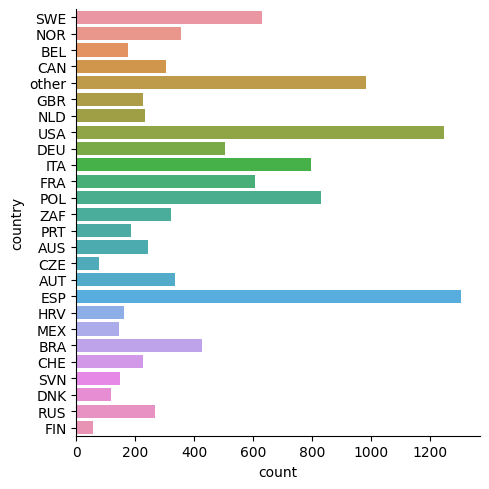

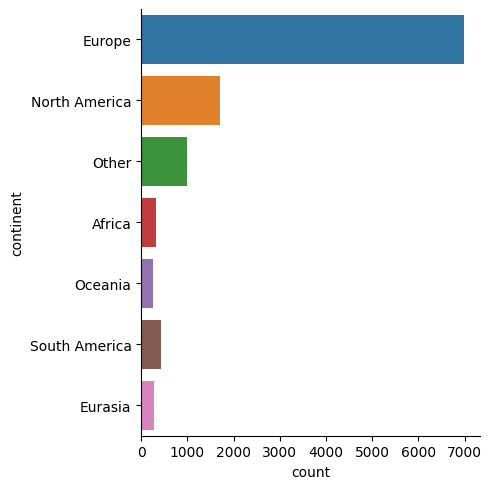

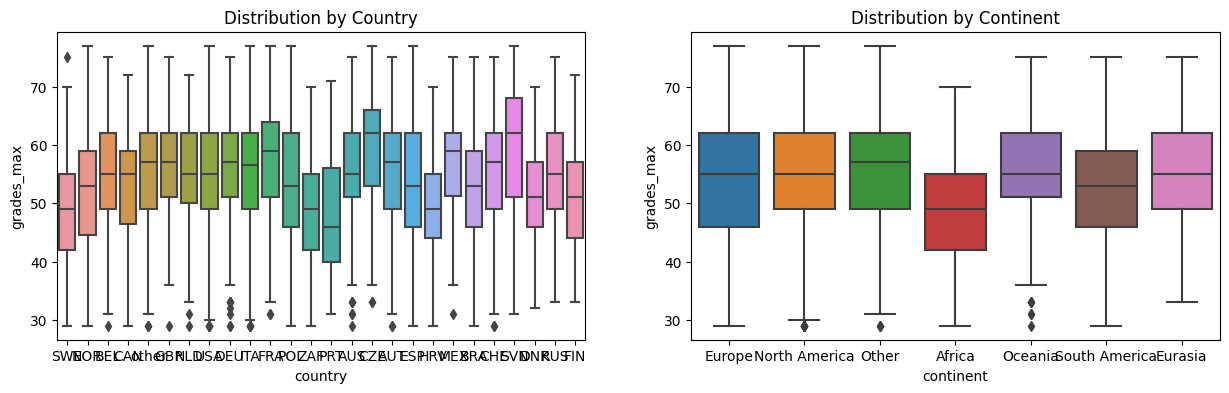

In [8]:
# Data Visualisation and Observations

# Countries in the Dataset
print("Number of Countries :", len(dataset_raw["country"].unique()))

continent_map = dict(
    **{a:"Europe" for a in ['ESP','POL','ITA','SWE','FRA','DEU','NOR','AUT','NLD','GBR',
                            'CHE','PRT', 'BEL', 'HRV', 'SVN', 'DNK', 'CZE', 'FIN']},
    **{a:"North America" for a in ['USA', 'CAN', 'MEX']},
    **{"BRA":"South America","ZAF":"Africa","AUS":"Oceania","RUS":"Eurasia", "other":"Other"}
)
# Grouping countries into continents
continent = dataset_cleaned.copy()
continent["continent"] = continent["country"].map(continent_map)

continent.country.value_counts()
# Climbers in each Continent
sb.catplot(y = "country", data = dataset_cleaned, kind = "count");
sb.catplot(y = "continent", data = continent, kind = "count");

# Compare distributions by country

fig, axis = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
axis[0].set_title("Distribution by Country")
sb.boxplot(x = 'country', y = 'grades_max', data = dataset_cleaned, ax=axis[0]);
axis[1].set_title("Distribution by Continent")
sb.boxplot(x = 'continent', y = 'grades_max', data = continent, ax=axis[1]);

In the case of Finalnd and the Czech Republic, the number of data points is extremely small which suggests that directly training our model on this country data could put the model at risk of overfitting.

Additionally, **we wish to generalise our model such that it is applicable to as many rock climbers as possible**. If our model was directly trained on these countries, it would be inapplicable to climbers who reside in countries outside of our dataset. 

Therefore, we perform the following steps:
1. Disregard the individual countries and group them by continent
1. Re-encode countries as integers
2. The order of encoding is based on some indicator (mean, upper quartile, lower quartile, median)

Grouping by continent, every continent has sufficient data to form a normal distribution (by the Central Limit Theorem). Hence this grouping is sufficient.

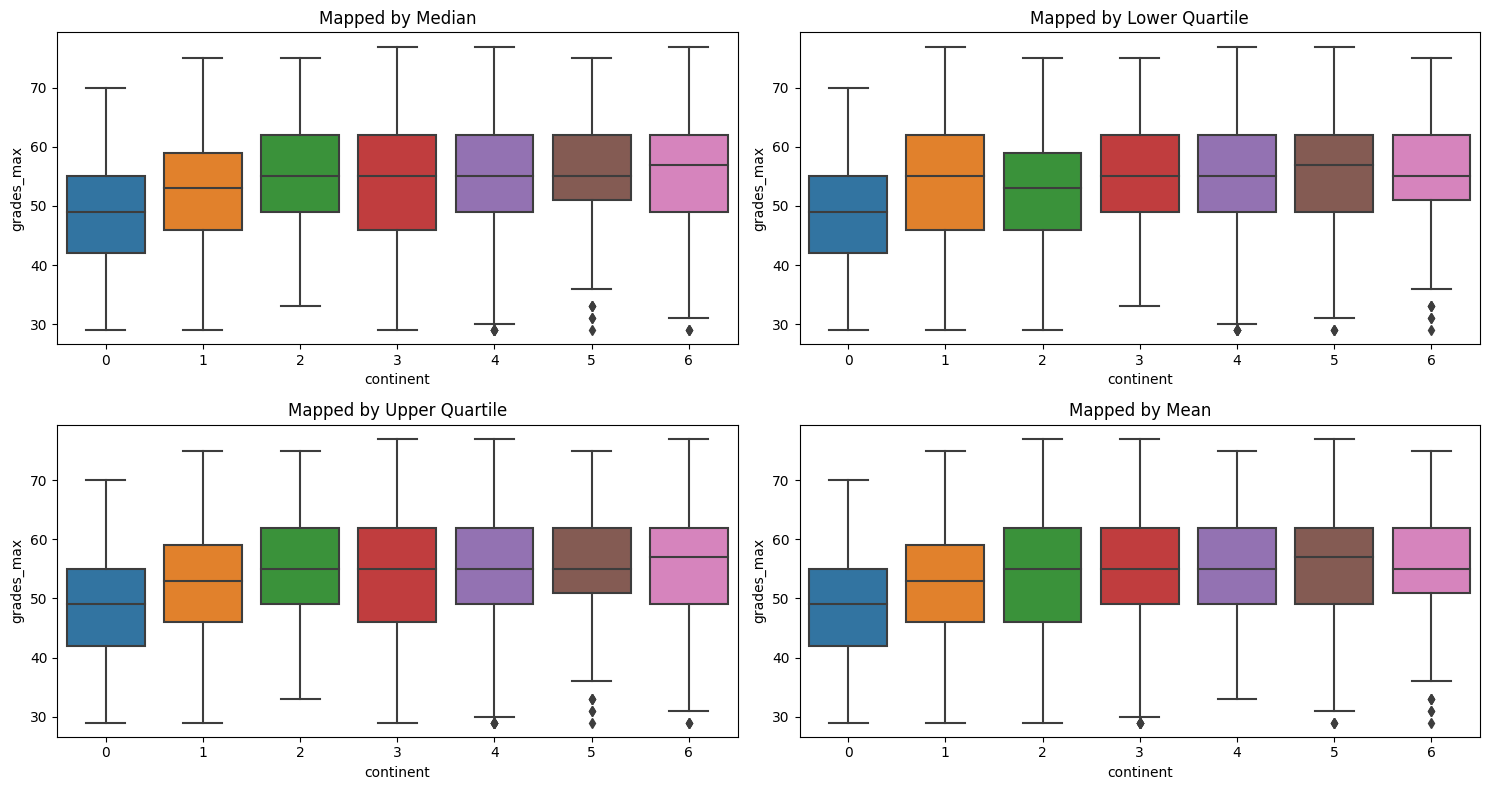

median_map  lower_map  upper_map  mean_map  grades_max
median_map    1.000000   0.759867   1.000000  0.877321    0.090876
lower_map     0.759867   1.000000   0.759867  0.880429    0.062337
upper_map     1.000000   0.759867   1.000000  0.877321    0.090876
mean_map      0.877321   0.880429   0.877321  1.000000    0.085376
grades_max    0.090876   0.062337   0.090876  0.085376    1.000000

In [9]:
# Helper function, remaps countries based on the provided indicator
def rank_countries(func):
    order = []
    for x in dataset_raw["country"].unique():
        order.append([func(x), x])
    order.sort()
    mapping = {a[1]:b for b, a in enumerate(order)}

    # Remap country values (if not already mapped)
    remapped = pd.DataFrame({"grades_max": dataset_cleaned["grades_max"],
                             "country": dataset_cleaned["country"].map(mapping)})
    return mapping, remapped

def rank_continents(func):
    order = []
    for x in continent["continent"].unique():
        order.append([func(x), x])
    order.sort()
    mapping = {a[1]:b for b, a in enumerate(order)}

    # Remap country values (if not already mapped)
    remapped = pd.DataFrame({"grades_max": dataset_cleaned["grades_max"],
                             "continent": continent["continent"].map(mapping)})
    return mapping, remapped

med_map, countries_med = rank_continents(lambda x: dataset_cleaned[continent["continent"]==x]["grades_max"].median())
hi_map, countries_hi = rank_continents(lambda x: dataset_cleaned[continent["continent"]==x]["grades_max"].quantile(0.75))
lo_map, countries_lo = rank_continents(lambda x: dataset_cleaned[continent["continent"]==x]["grades_max"].quantile(0.25))
mean_map, countries_mean = rank_continents(lambda x: dataset_cleaned[continent["continent"]==x]["grades_max"].mean())

# Display results
fig, axis = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(15)
axis[0,0].set_title("Mapped by Median")
sb.boxplot(x = 'continent', y = 'grades_max', data = countries_med, ax = axis[0,0]);
axis[0,1].set_title("Mapped by Lower Quartile")
sb.boxplot(x = 'continent', y = 'grades_max', data = countries_lo, ax = axis[0,1]);
axis[1,0].set_title("Mapped by Upper Quartile")
sb.boxplot(x = 'continent', y = 'grades_max', data = countries_hi, ax = axis[1,0]);
axis[1,1].set_title("Mapped by Mean")
sb.boxplot(x = 'continent', y = 'grades_max', data = countries_mean, ax = axis[1,1]);

fig.tight_layout()
plt.show()

# Compare correlation and choose a mapping to use
country_corr = pd.DataFrame({
                "median_map": countries_med["continent"],
                "lower_map": countries_lo["continent"],
                "upper_map": countries_hi["continent"],
                "mean_map": countries_mean["continent"],
                "grades_max": dataset_cleaned["grades_max"],
                })
display(country_corr.corr())
plt.show()

We select **mean** as the most representative indicator due to its highest correlation, and map continents to numerical values.

In [10]:
print("Chosen Mapping: Upper Quartile\n\n", hi_map)
dataset_cleaned["continent"] = countries_hi["continent"]

print("\nRemapped country column by mean")

Chosen Mapping: Upper Quartile

 {'Africa': 0, 'South America': 1, 'Eurasia': 2, 'Europe': 3, 'North America': 4, 'Oceania': 5, 'Other': 6}

Remapped country column by mean


### Height and Weight
First, we observe that:
1. Data is scalar and stored as integers for both variables
2. Plotting their distributions give relatively balanced normal distributions:
  * The distribution of weight is slightly odd, but still follows a bell-curve shape. The 'wavelike' shape of its distribution could be from rounding errors when reporting the weight of each climber
3. Running a correlation heatmap gives us relatively low correlation to both variables

As suggested by the initial correlation heatmap, height and weight are closely related features. In fact, we can use both variables to obtain Body Mass Indicator (BMI) as such:

$BMI = \frac{weight/kg}{[height/m]^2}$

<AxesSubplot: >

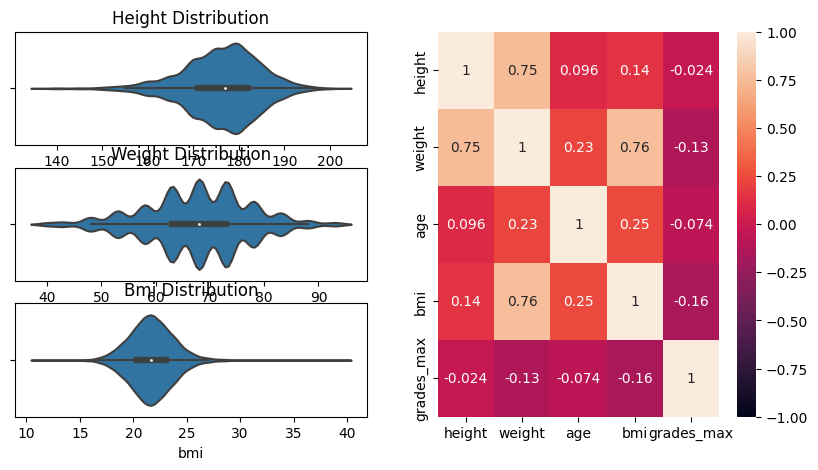

In [11]:
fig, axis = plt.subplots(3, 2)
fig.set_figheight(5)
fig.set_figwidth(10)
axis[0,0].set_title("Height Distribution")
sb.violinplot(x = 'height', data = dataset_cleaned, ax = axis[0,0]);
axis[1,0].set_title("Weight Distribution")
sb.violinplot(x = 'weight', data = dataset_cleaned, ax = axis[1,0]);


gs = axis[0, 1].get_gridspec()
for ax in axis[0:, -1]: ax.remove()
axbig = fig.add_subplot(gs[0:, -1])

# Calculate bmi and perform correlation
bmi = pd.DataFrame({
    "height": dataset_cleaned["height"],
    "weight": dataset_cleaned["weight"],
    "age": dataset_cleaned["age"],
    "bmi": dataset_cleaned["weight"]/dataset_cleaned["height"]/dataset_cleaned["height"]*10000,
    "grades_max": dataset_cleaned["grades_max"]
})

axis[2,0].set_title("Bmi Distribution")
sb.violinplot(x = 'bmi', data = bmi, ax = axis[2,0]);

sb.heatmap(bmi.corr(),vmin = -1,vmax = 1, annot=True, ax=axbig)

We see that the correlation of `bmi` with `grades_max` has improved from the original height and weight correlation, suggesting that BMI is a useful transformation on the raw values of height and weight.

In [12]:
# Add bmi to dataset_cleaned
dataset_cleaned["bmi"] = bmi["bmi"]
print("CONCLUSION: Added bmi")

CONCLUSION: Added bmi


### Climbing Durations
`years_cl` is described by the dataset author as the number of "years climbing". However, this information is insufficient:
1. "Years climbing" may refer to the number of years spent climbing regulary, or the number of years since the first climb (The climber may no longer be active). It is assumed when calculating `start_age` that it refers to the latter.
2. We can convert `years_cl` to `days_cl` with the approximation: $days\_climbed = years\_climbed*365$
3. Taking the difference between `date_first` and `date_last` (We name this variable `days_diff`) gives another measure of days spent climbing which has a vastly different distribution from `years_cl`.
4. We can also obtain the frequency that the climber did climbs while he was active using the formula:  
   $frequency=\frac{grades\_count}{number\_of\_days}$

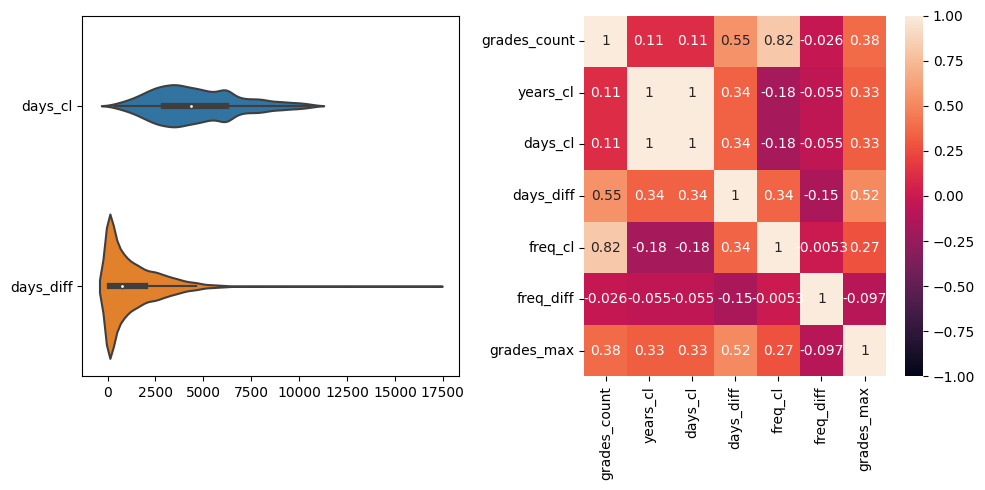

In [15]:
from datetime import datetime

fmt = "%Y-%m-%d %H:%M:%S"
duration = pd.DataFrame({
    "grades_count": dataset_cleaned["grades_count"],
    "years_cl": dataset_cleaned["years_cl"],
    "days_cl": dataset_cleaned["years_cl"]*365
})

def get_days_diff(row):
    fmt = "%Y-%m-%d %H:%M:%S"
    date_first = datetime.strptime(row["date_first"], fmt)
    date_last = datetime.strptime(row["date_last"], fmt)
    return abs((date_last - date_first).days)

# Use apply method to calculate the difference in days for all rows
days_diff = dataset_cleaned.apply(get_days_diff, axis=1)

# Add the days_diff column to the duration DataFrame
duration["days_diff"] = days_diff

duration["freq_cl"] = dataset_cleaned["grades_count"]/duration["days_cl"]
duration["freq_diff"] = dataset_cleaned["grades_count"]/duration["days_diff"]
duration["grades_max"] = dataset_cleaned["grades_max"]

fig, axis = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(10)
sb.violinplot(data = duration[["days_cl", "days_diff"]], orient='h', ax = axis[0]);
sb.heatmap(duration.corr(),vmin = -1,vmax = 1, annot=True)

fig.tight_layout()
plt.show()

It was noticed that `date_first` and `date_last` are sometimes reversed, so an abs() function was performed to fix this issue. Additionally, some values of `days_diff` are larger than `years_cl` which suggests **there is erroneous data that must be removed later**.

* `days_diff` has a far stronger correlation to `grades_max` than `days_cl`
* Both versions of frequency have a lower correlation to `grades_max` than their original variables
* There is a significant skew in the distribution of `days_diff` which suggests that a logarithmic function should be applied to the feature in later steps.

In our original problem statement, `days_diff` and `days_cl` both describe a future state and are hence mutually exclusive variables. **Therefore, we will use `days_diff` instead of `years_cl` for subsequent model training.**

In [16]:
# Add days_diff
dataset_cleaned["days_diff"] = duration["days_diff"]
print("CONCLUSION: days_diff added")

CONCLUSION: days_diff added


### Age
It is observed that the distribution of age is relatively normal and its correlation to `grades_max` is extremely low.

**Asssuming that `years_cl` represents the number of years since an individual has started climbing, and age represents the current age of an individual**, subtracting `years_cl` can give us the age that an individual started climbing.

$start\_age = age-years\_cl$

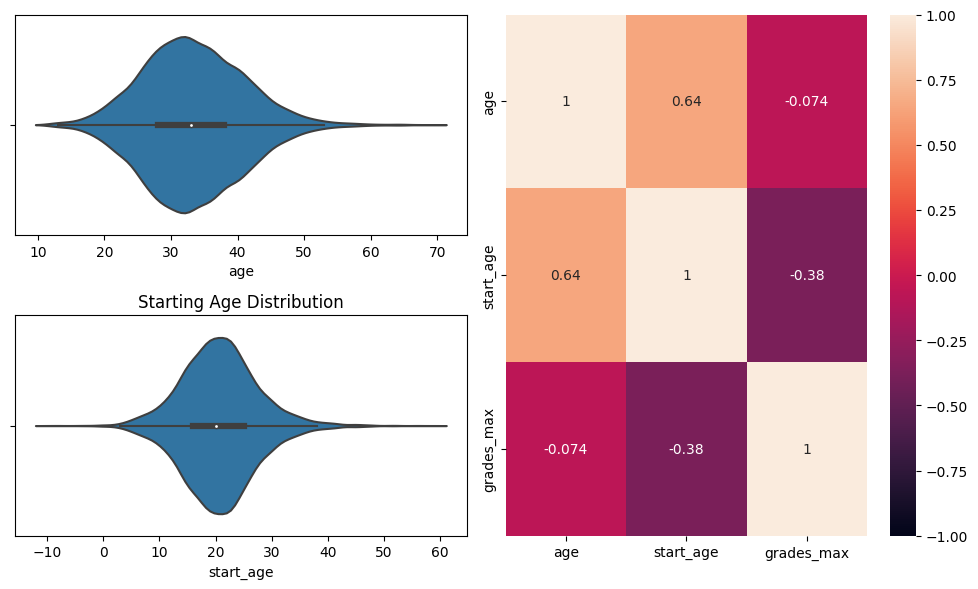

In [13]:
# Plot distribution of age
fig, axis = plt.subplots(2, 2)
fig.set_figheight(6)
fig.set_figwidth(10)
gs = axis[0, 1].get_gridspec()
for ax in axis[0:, -1]: ax.remove()
axbig = fig.add_subplot(gs[0:, -1])

# Calculate start age and perform correlation
age = pd.DataFrame({
    "age": dataset_cleaned["age"],
    "start_age": dataset_cleaned["age"]-dataset_cleaned["years_cl"],
    "grades_max": dataset_cleaned["grades_max"]
})

axis[1,0].set_title("Age Distribution")
sb.violinplot(x = 'age', data = age, ax = axis[0,0]);
axis[1,0].set_title("Starting Age Distribution")
sb.violinplot(x = 'start_age', data = age, ax = axis[1,0]);

sb.heatmap(age.corr(),vmin = -1,vmax = 1, annot=True, ax=axbig)
fig.tight_layout()
plt.show()

This allows us to obtain `start_age` which follows a normal distribution, and also has a significant correlation to `grades_max`. `start_age` also reveals that some values of `years_cl` are infeasible as they are larger than current reported age. This is likely because `years_cl` contains erroneous data:
1. Individuals might have reported the age that they started climbing instead of their current age
2. Data could have been incorrectly recorded

These issues will be addressed in the outliers section.

In [14]:
dataset_cleaned["start_age"] = age["start_age"]
print("CONCLUSION: Added start_age")

CONCLUSION: Added start_age


### Outliers

Having added relevant predictors to our model, we can plot boxplots for our features to identify outliers: 

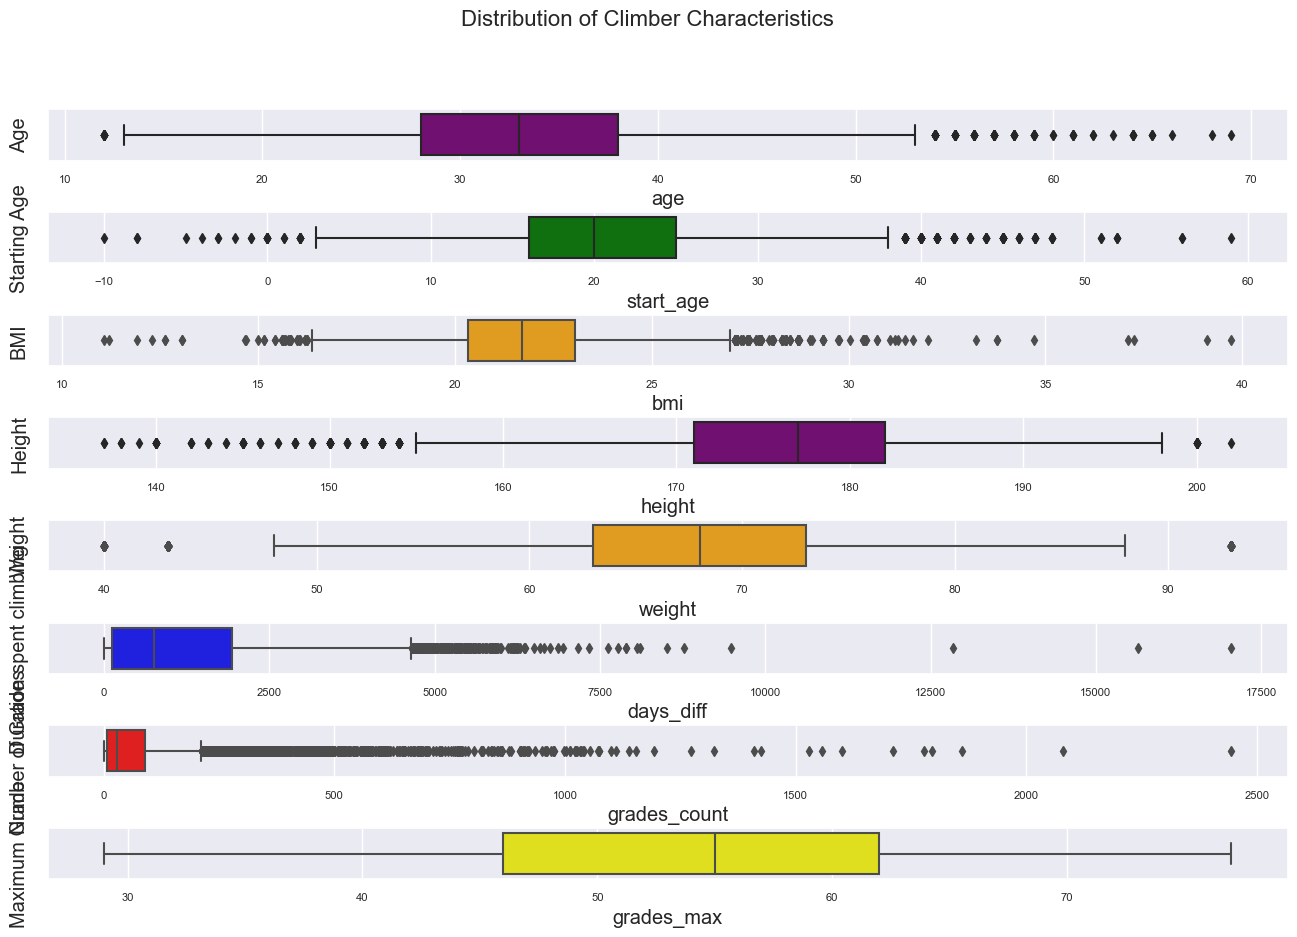

In [41]:
outliers = dataset_cleaned.copy()

f, axes = plt.subplots(8, 1, figsize=(16, 10))

sb.boxplot(x = outliers["age"],orient = "h", ax = axes[0], color="purple")
axes[0].set_ylabel("Age")
axes[0].tick_params(axis='x', labelsize=8)

sb.boxplot(x = outliers["start_age"],orient = "h", ax = axes[1], color="green")
axes[1].set_ylabel("Starting Age")
axes[1].tick_params(axis='x', labelsize=8)

sb.boxplot(x = outliers["bmi"], orient = "h", ax = axes[2], color="orange")
axes[2].set_ylabel("BMI")
axes[2].tick_params(axis='x', labelsize=8)

sb.boxplot(x = outliers["height"],orient = "h", ax = axes[3], color="purple")
axes[3].set_ylabel("Height")
axes[3].tick_params(axis='x', labelsize=8)

sb.boxplot(x = outliers["weight"],orient = "h", ax = axes[4], color="orange")
axes[4].set_ylabel("Weight")
axes[4].tick_params(axis='x', labelsize=8)

sb.boxplot(x = outliers["days_diff"], orient = "h", ax = axes[5], color="blue")
axes[5].set_ylabel("Duration spent climbing")
axes[5].tick_params(axis='x', labelsize=8)

sb.boxplot(x = outliers["grades_count"], orient = "h", ax = axes[6], color="red")
axes[6].set_ylabel("Number of Grades")
axes[6].tick_params(axis='x', labelsize=8)

sb.boxplot(x = outliers["grades_max"], orient = "h", ax = axes[7], color="yellow")
axes[7].set_ylabel("Maximum Grade")
axes[7].tick_params(axis='x', labelsize=8)

plt.subplots_adjust(hspace=1)
plt.suptitle("Distribution of Climber Characteristics", fontsize=16);

We observe that there is significant skew for certain features `grades_count` and `days_diff`, which suggests that applying a logarithmic transformation to those features could better normalise its data.

We can identify the following outliers in our features:

1. As mentioned earlier, some values of `start_age` are completely infeasible as they are below or equal to 0. This is possibly due to individuals reporting their age at the time of their first climb instead of their current age.

2. As mentioned earlier, some values of `days_diff` appear erroneous as they are significantly larger than the `years_cl` variable.

3. `continent` contains an additional "Other" value that is mapped to the highest numerical value. It is uncertain what this "Other" column might represent.

These anomalies must be removed from the data as it is unclear how they should be otherwise interpreted.

> We remove any `start_age` less than 4 as it is not recommended to be climbing at those ages

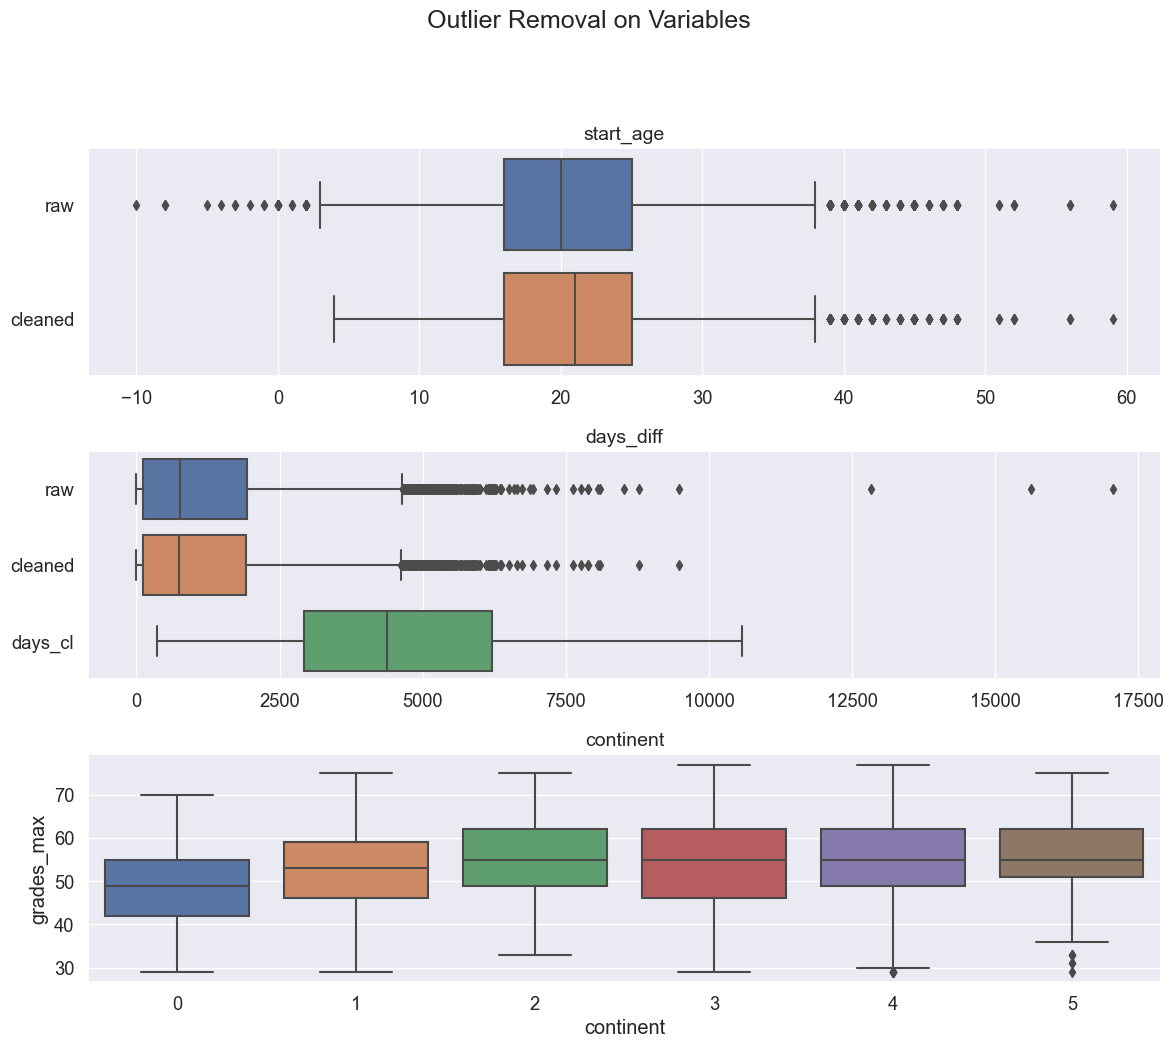

Values for continent: ['Africa', 'South America', 'Eurasia', 'Europe', 'North America', 'Oceania']


In [47]:
# create a grid of subplots for the boxplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

# Removing invalid start_age
outliers = outliers[outliers["start_age"]>3]
sb.boxplot(data = pd.DataFrame({"raw": dataset_cleaned["start_age"], "cleaned": outliers["start_age"]}), orient='h', ax = axes[0]);
axes[0].set_title("start_age", fontsize=14)

# Removing invalid days_diff
outliers = outliers[outliers["days_diff"]<(outliers["years_cl"]*365)]
sb.boxplot(data = pd.DataFrame({"raw": dataset_cleaned["days_diff"], "cleaned": outliers["days_diff"], "days_cl": dataset_cleaned["years_cl"]*365}), orient='h', ax = axes[1]);
axes[1].set_title("days_diff", fontsize=14)

# Removing unknown continents
outliers = outliers[outliers["continent"] != hi_map["Other"]]
sb.boxplot(x = 'continent', y = 'grades_max', data = outliers, ax = axes[2]);
axes[2].set_title("continent", fontsize=14)

# q1, q2, q3 = np.percentile(outliers["grades_count"], [25, 50, 75])
# iqr = q3 - q1
# lower_bound = q1 - 1.5 * iqr
# upper_bound = q3 + 1.5 * iqr
# outliers = outliers[(outliers["grades_count"] >= lower_bound) & (outliers["grades_count"] <= upper_bound)]
# sb.boxplot(data=pd.DataFrame({"raw": dataset_cleaned["grades_count"], "cleaned": outliers["grades_count"]}), orient='h', ax=axes[3]);
# axes[3].set_title("grades_count", fontsize=14)

# main title
fig.suptitle("Outlier Removal on Variables", fontsize=18, y=1.05)

# adjust the spacing between the subplots
fig.tight_layout()
plt.show()
print("Values for continent:", [x for x in hi_map if hi_map[x] in outliers["continent"].unique()])

dataset_cleaned1 = outliers[["continent", "sex", "age", "start_age", "height", "weight", "bmi", "days_diff", "grades_count", "grades_first", "grades_max"]]

### Correlation Heatmap
A final review of our changes to the dataset:
* `grades_last` and `grades_mean` are alternative response variables and will not be used
* `country` has been generalised to `continent`
* `bmi`, `start_age` and `days_diff` have been added
* Erroneous data and outliers has been removed

With these changes, we can build a final correlation heatmap and scatterplot to visualise our features' correlation to `grades_max`.

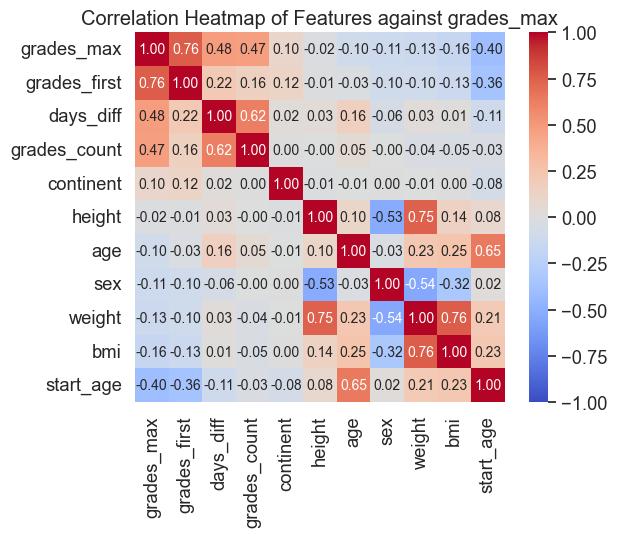

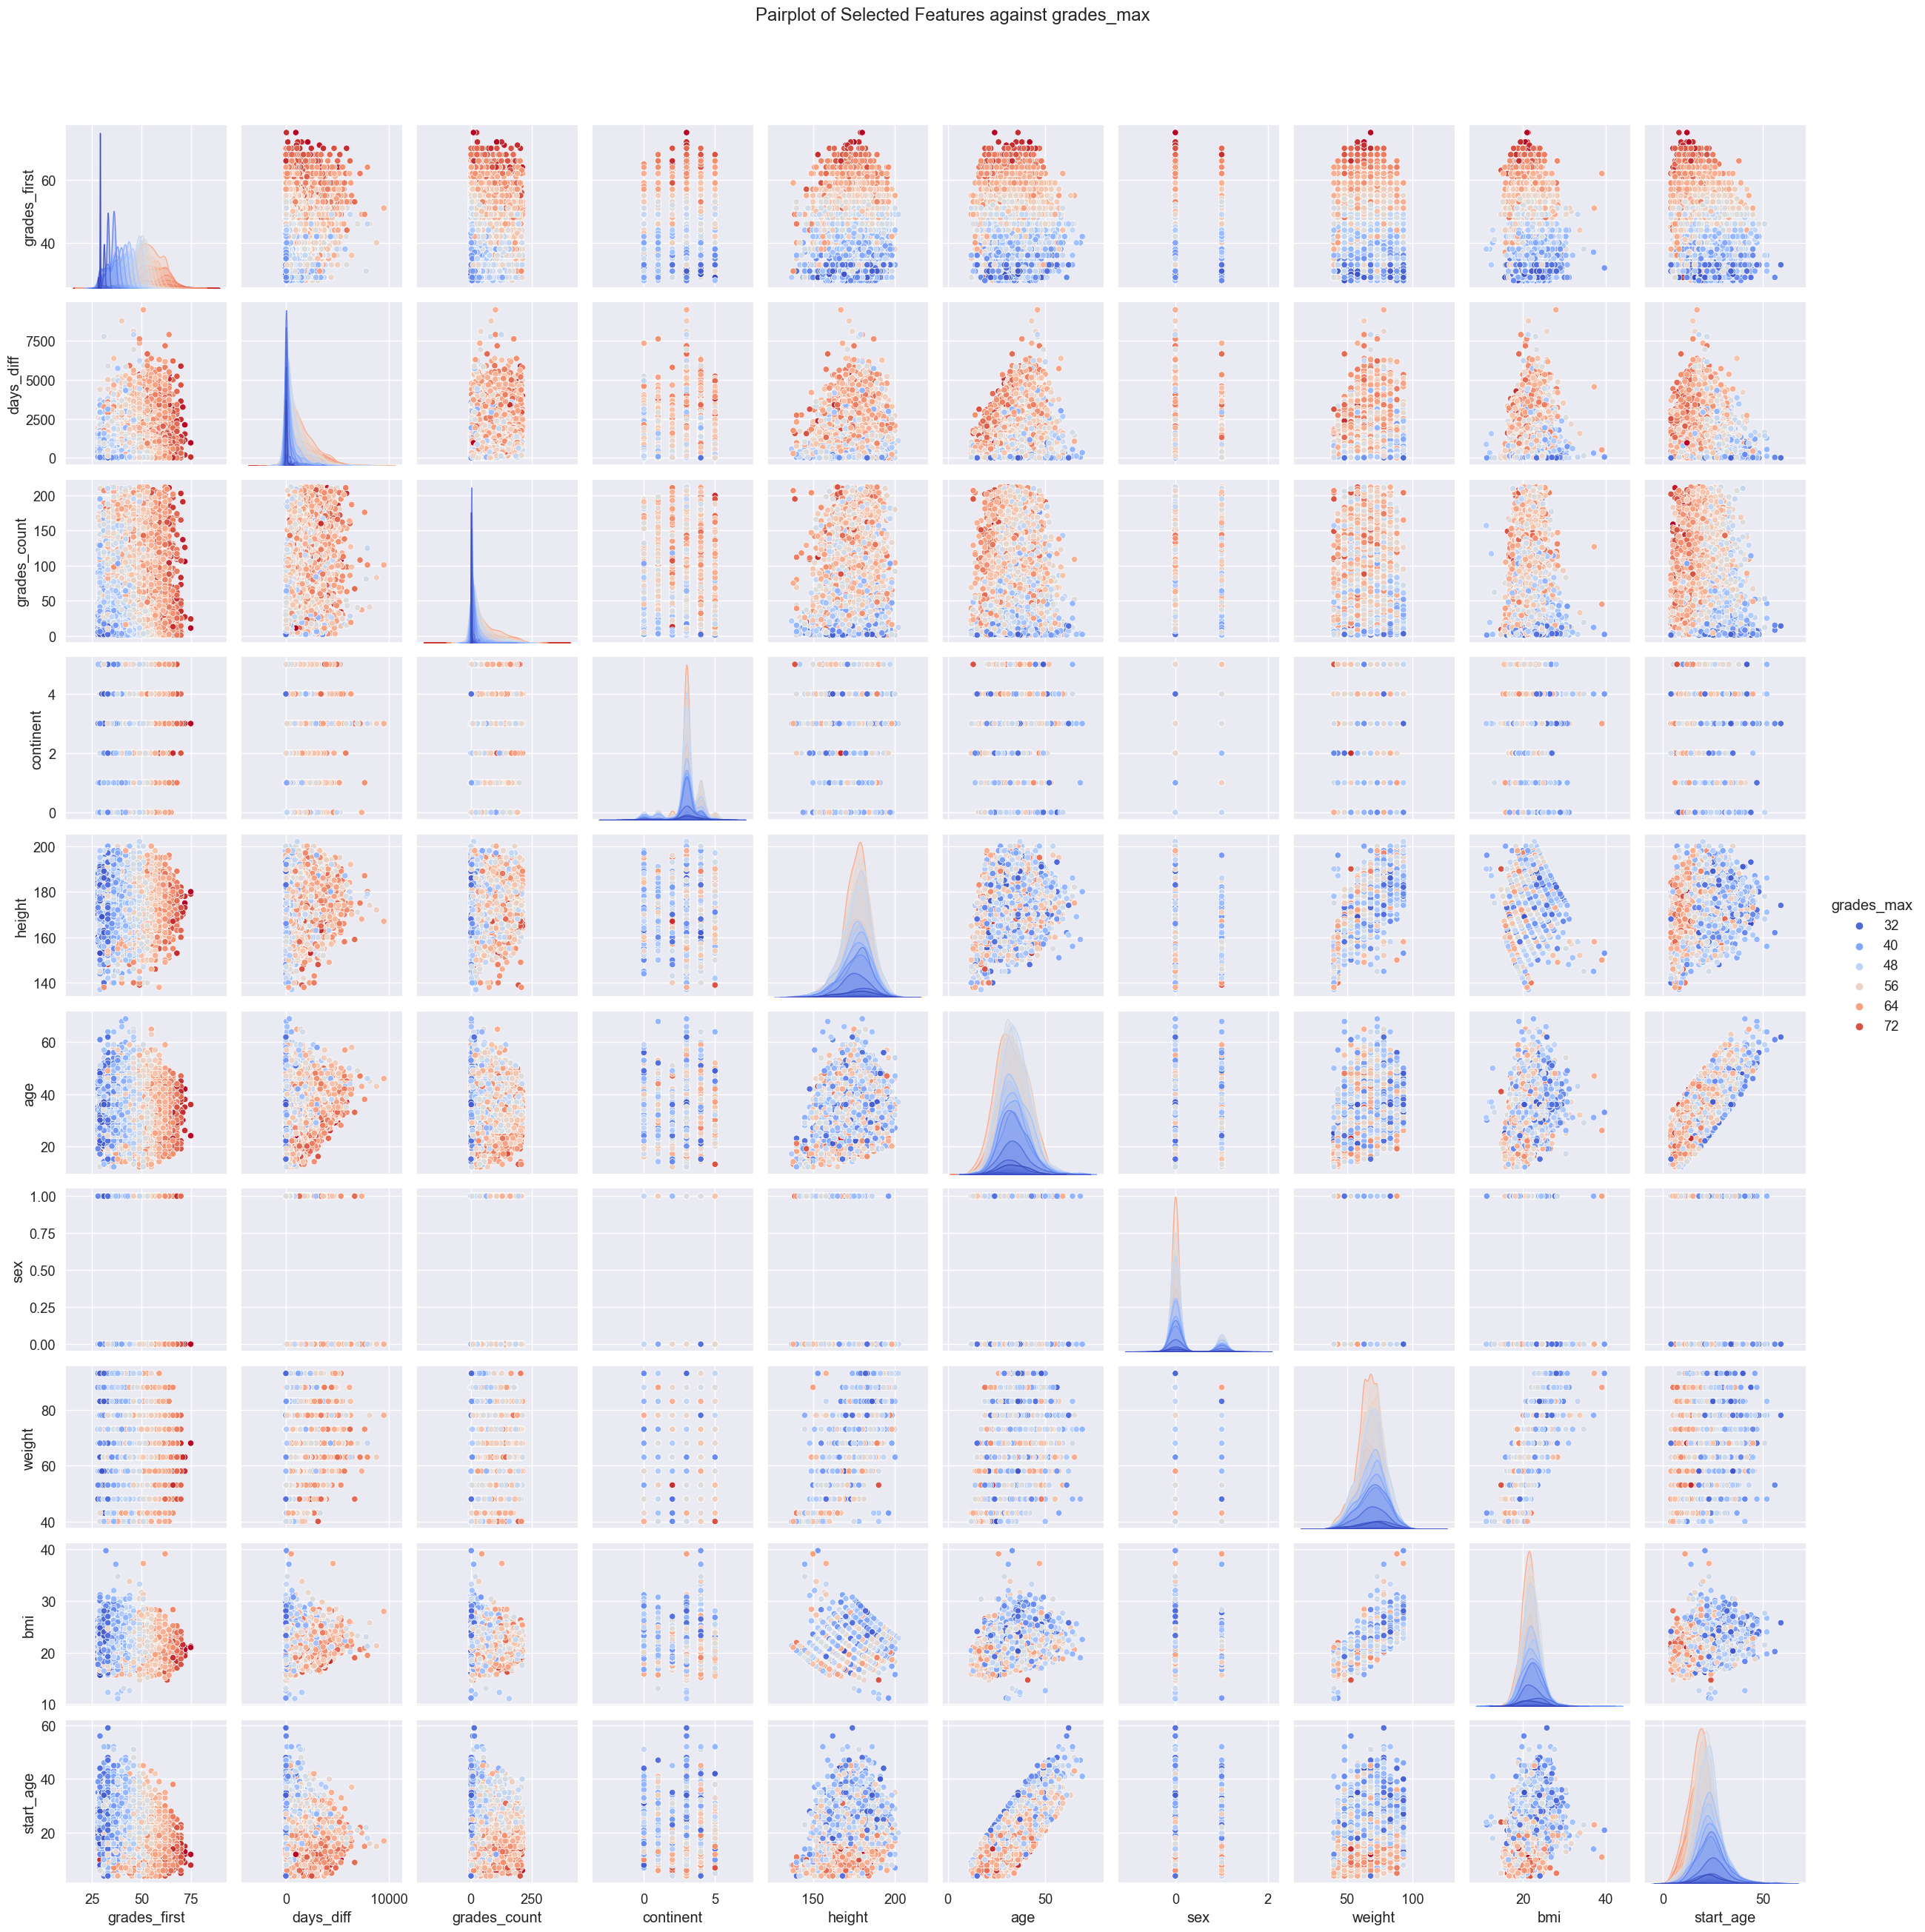

In [19]:
corr_matrix = dataset_cleaned1.corr(numeric_only=True)

k = 11 #number of variables for heatmap
cols = corr_matrix.nlargest(k, 'grades_max')['grades_max'].index
cm = np.corrcoef(dataset_cleaned1[cols].values.T)
sb.set(font_scale=1.2)
hm = sb.heatmap(cm, cbar=True, annot=True, square=True, vmin=-1, vmax=1, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap="coolwarm")
hm.set_title('Correlation Heatmap of Features against grades_max')
plt.show()

# Pairplot of Selected Features
# sb.pairplot(dataset_cleaned1[cols.values], hue='grades_max', palette='coolwarm')
# plt.suptitle("Pairplot of Selected Features against grades_max", y=1.05)
plt.show()

## Machine Learning
In this section, we do an initial linear regression, and subsequently use it to find optimal exponents for our variables. Next, we normalise our data and use them ot train K-Nearest-Neighbours and Support Vector Machine models.
* [Linear Regression](#linear-regression)
* [Support Vector Machine (SVM)](#support-vector-machine)
* [K-Nearest-Neighbours (KNN)](#k-nearest-neighbours)


### Linear Regression
Performing linear regression on the current variables gives:

    Goodness of Fit of Model 	Train Dataset

    Explained Variance (R^2) 	: 0.7407844588686892

    Mean Squared Error (MSE) 	: 23.893798861817668


    Goodness of Fit of Model 	Test Dataset

    Explained Variance (R^2) 	: 0.7416705650537425

    Mean Squared Error (MSE) 	: 22.98636667055127


We use the default sklearn train_test_split function with a train-test split of 80-20 for all of our models.

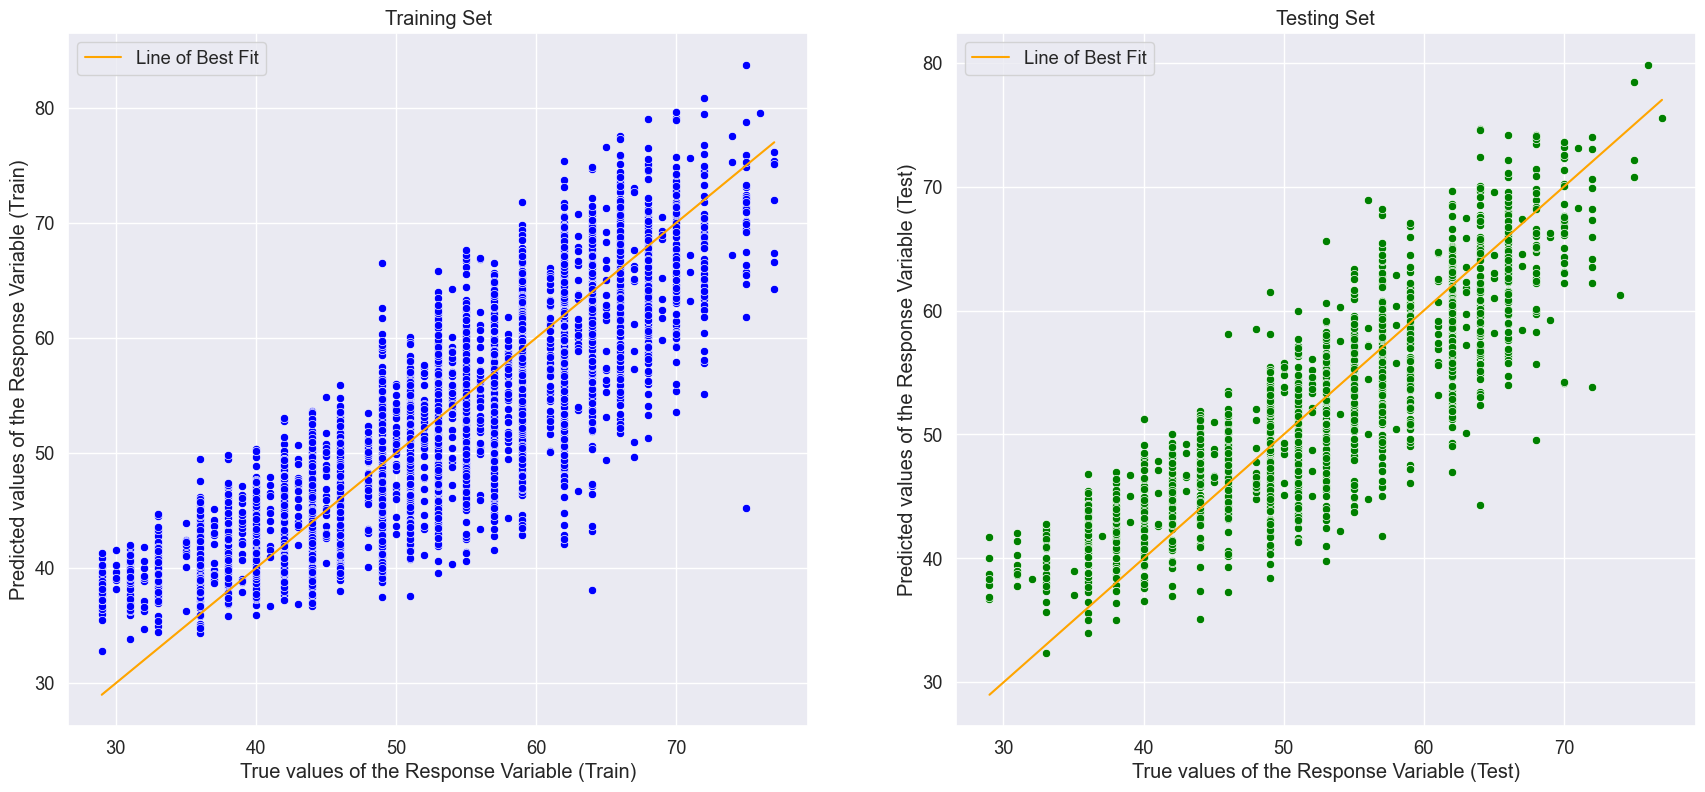

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.7461852267352906
Mean Squared Error (MSE) 	: 23.41091935571351

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.7457133404571681
Mean Squared Error (MSE) 	: 22.568566226469244



0.7457133404571681

In [25]:
def linear_reg(dataset, plot=False, test_size=0.2, random_state=None):

    predictors = dataset.drop(columns=["grades_max"])
    response = pd.DataFrame(dataset["grades_max"])

    predictors_train, predictors_test, response_train, response_test = train_test_split(predictors, response, test_size = test_size, random_state = random_state)

    lr = LinearRegression().fit(predictors_train, response_train)

    response_train_pred = lr.predict(predictors_train)
    response_test_pred = lr.predict(predictors_test)
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(21, 9))
        sb.scatterplot(x=response_train['grades_max'], y=response_train_pred.flatten(), color='blue', marker='o', ax=axes[0])
        sb.lineplot(x=response_train['grades_max'], y=response_train['grades_max'], color='orange', ax=axes[0], label='Line of Best Fit')
        axes[0].set_xlabel("True values of the Response Variable (Train)")
        axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
        axes[0].set_title("Training Set")
        axes[0].grid(True)

        sb.scatterplot(x=response_test['grades_max'], y=response_test_pred.flatten(), color='green', marker='o', ax=axes[1])
        sb.lineplot(x=response_test['grades_max'], y=response_test['grades_max'], color='orange', ax=axes[1], label='Line of Best Fit')
        axes[1].set_xlabel("True values of the Response Variable (Test)")
        axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
        axes[1].set_title("Testing Set")
        axes[1].grid(True)

        plt.show()

        # Check the Goodness of Fit (on Train Data)
        print("Goodness of Fit of Model \tTrain Dataset")
        print("Explained Variance (R^2) \t:", lr.score(predictors_train, response_train))
        print("Mean Squared Error (MSE) \t:", mean_squared_error(response_train, response_train_pred))
        print()

        # Check the Goodness of Fit (on Test Data)
        print("Goodness of Fit of Model \tTest Dataset")
        print("Explained Variance (R^2) \t:", lr.score(predictors_test, response_test))
        print("Mean Squared Error (MSE) \t:", mean_squared_error(response_test, response_test_pred))
        print()
    
    return lr.score(predictors_test, response_test
)

linear_reg(dataset_cleaned1, plot=True)

We can observe that there is a slight curvature in both the graph of the training set and testing set, where there are more data points below the line of best fit.

This implies that the Linear Regression Model fails to account for the non-linearity of provided features, and exponents may be applied to improve this behaviour.

#### Hypertuning Parameters
To improve the linear regression, we can explore the effect of varying exponents on each variable. Plotting explained variance against exponent for different features provides us with interesting results:

In [38]:
# Normalise the dataset
dataset_norm = dataset_cleaned1.copy()

for col in dataset_norm.columns:
    if col=="grades_max": continue
    mean = dataset_cleaned1[col].mean()
    std = dataset_cleaned1[col].std()
    dataset_norm[col] = [(v-mean)/std for v in dataset_cleaned1[col]]

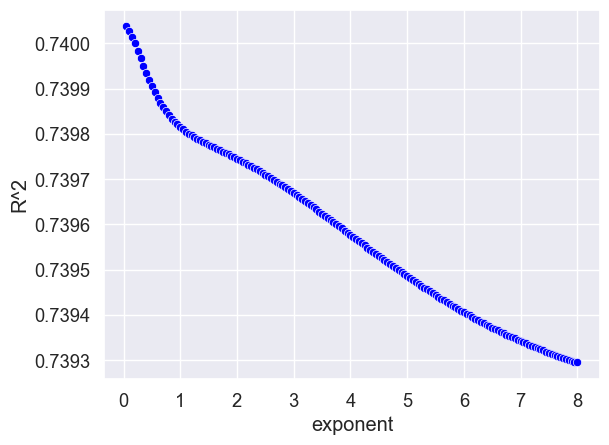

Optimal Exponent for continent: 0.05


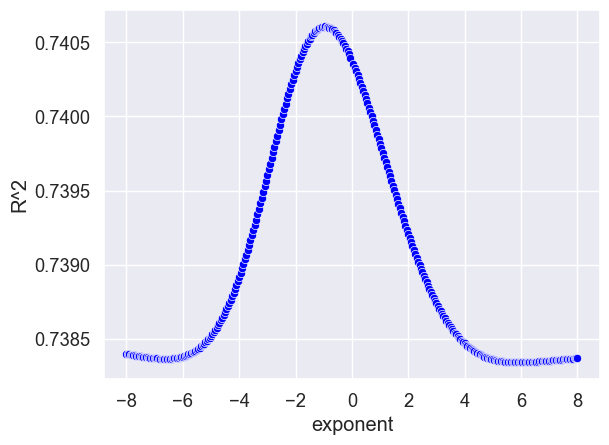

Optimal Exponent for age: -0.95


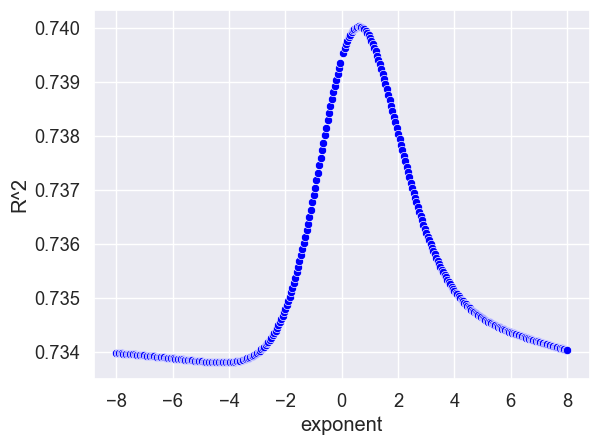

Optimal Exponent for start_age: 0.6


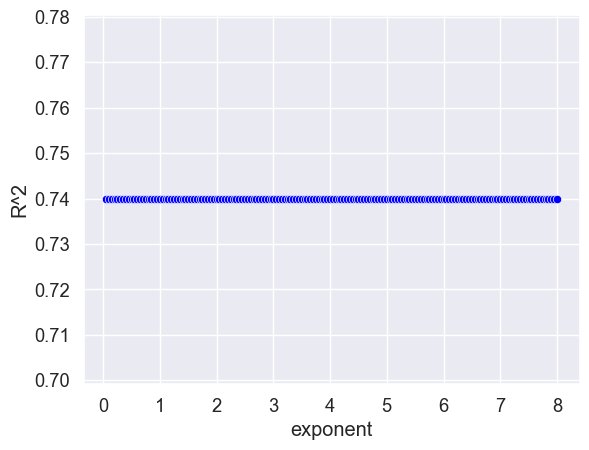

Optimal Exponent for sex: 0.05


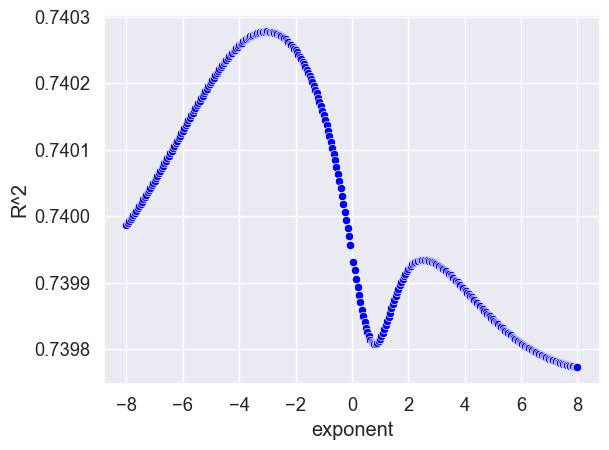

Optimal Exponent for bmi: -3.05


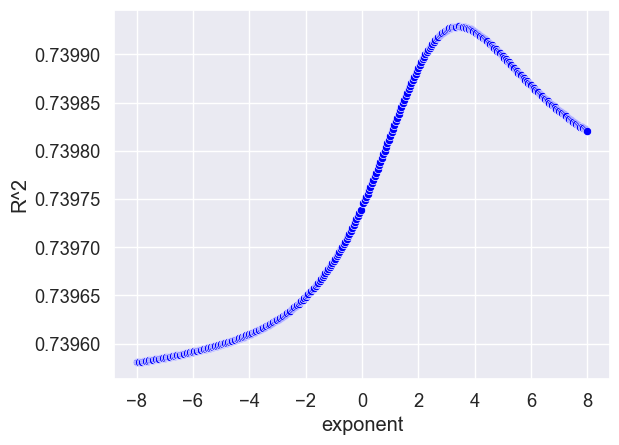

Optimal Exponent for height: 3.4


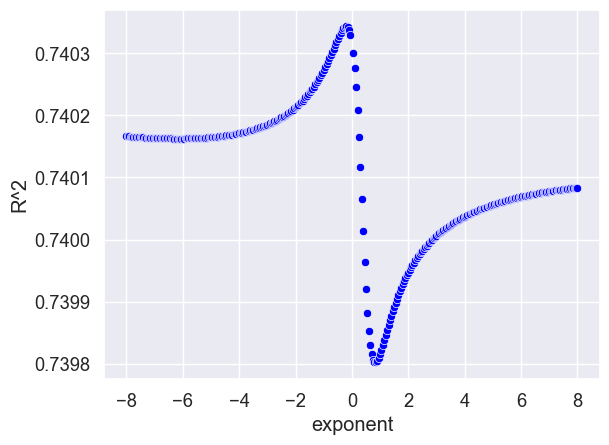

Optimal Exponent for weight: -0.2


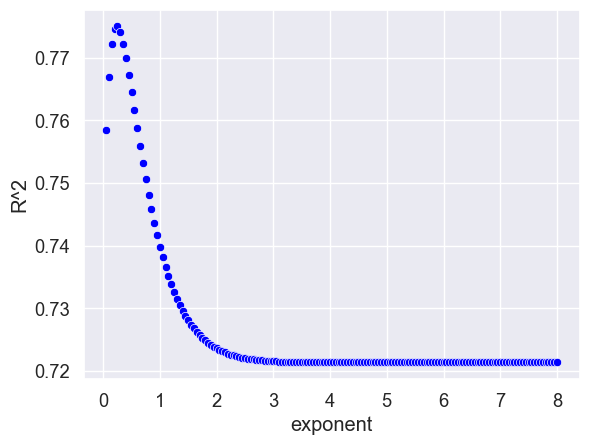

Optimal Exponent for days_diff: 0.25


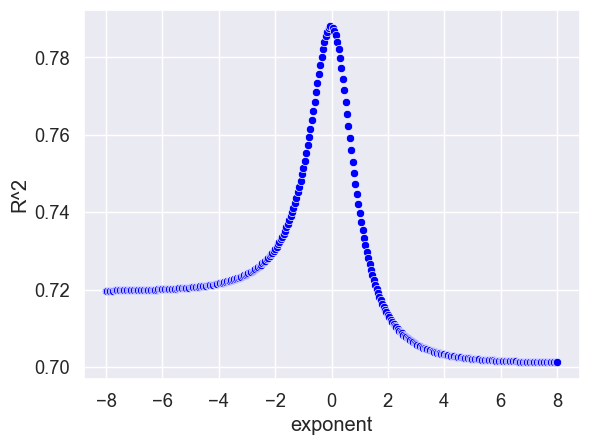

Optimal Exponent for grades_count: -0.05


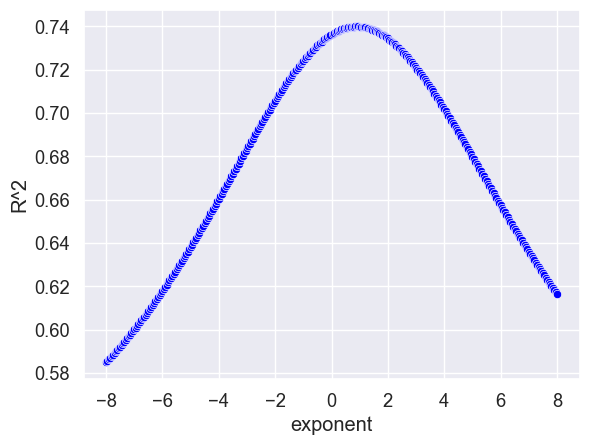

Optimal Exponent for grades_first: 0.9


In [54]:
warnings.filterwarnings("ignore")

def plot_var(col):
    res = pd.DataFrame({"exponent":[], "R^2":[]})
    dataset = dataset_norm.copy()
    state = 69420
    for e in range(-160, 161):
        try:
            dataset[col] = pow(dataset_cleaned1[col], e/20)
            mean = dataset[col].mean()
            std = dataset[col].std()
            dataset[col] = [(v-mean)/std for v in dataset[col]]
            res.loc[len(res)] = {"exponent":e, "R^2":linear_reg(dataset, random_state=state)}
        except:
            pass
    return res

exponents = {}
# sb.scatterplot(x=grades_count['exponent'], y=grades_count["R^2"], color='blue', marker='o')
for col in ["continent", "age", "start_age", "sex", "bmi", "height", "weight", "days_diff", "grades_count", "grades_first"]:
    vals = plot_var(col)
    exponents[col] = vals.nlargest(1, "R^2")["exponent"].mean()/20
    sb.scatterplot(x=vals['exponent']/20, y=vals['R^2'], color='blue', marker='o')
    plt.show()
    print("Optimal Exponent for {}:".format(col), exponents[col])

We can observe visually that there exists an optimal value for exponent that maximises the accuracy of our model. Obtaining these values for all of our predictors gives a list of exponents that can be applied to our variables.

> It is important to normalise the data to unit variance for this step as applying exponents can cause a variable to become overpower the linear regression model.

In [55]:
print("optimal exponents:", exponents)

optimal exponents: {'continent': 0.05, 'age': -0.95, 'start_age': 0.6, 'sex': 0.05, 'bmi': -3.05, 'height': 3.4, 'weight': -0.2, 'days_diff': 0.25, 'grades_count': -0.05, 'grades_first': 0.9}


We can observe:
1. Exponents for `days_diff` and `grades_count` are logarithmic and strongly reflect our initial observations about their skew
2. `grades_first` has an exponent close to 1. This is expected as it should experience a similar scaling to our `grades_max` response variable
3. This method of exponent-finding does not work well on categorical variables such as sex and continent. Hence, we intentionally restore the exponents of these features back to 1.

In [56]:
exponents["continent"]=1
exponents["sex"]=1
exponents["grades_first"]=1
print("fixed exponents:",exponents)

fixed exponents: {'continent': 1, 'age': -0.95, 'start_age': 0.6, 'sex': 1, 'bmi': -3.05, 'height': 3.4, 'weight': -0.2, 'days_diff': 0.25, 'grades_count': -0.05, 'grades_first': 1}


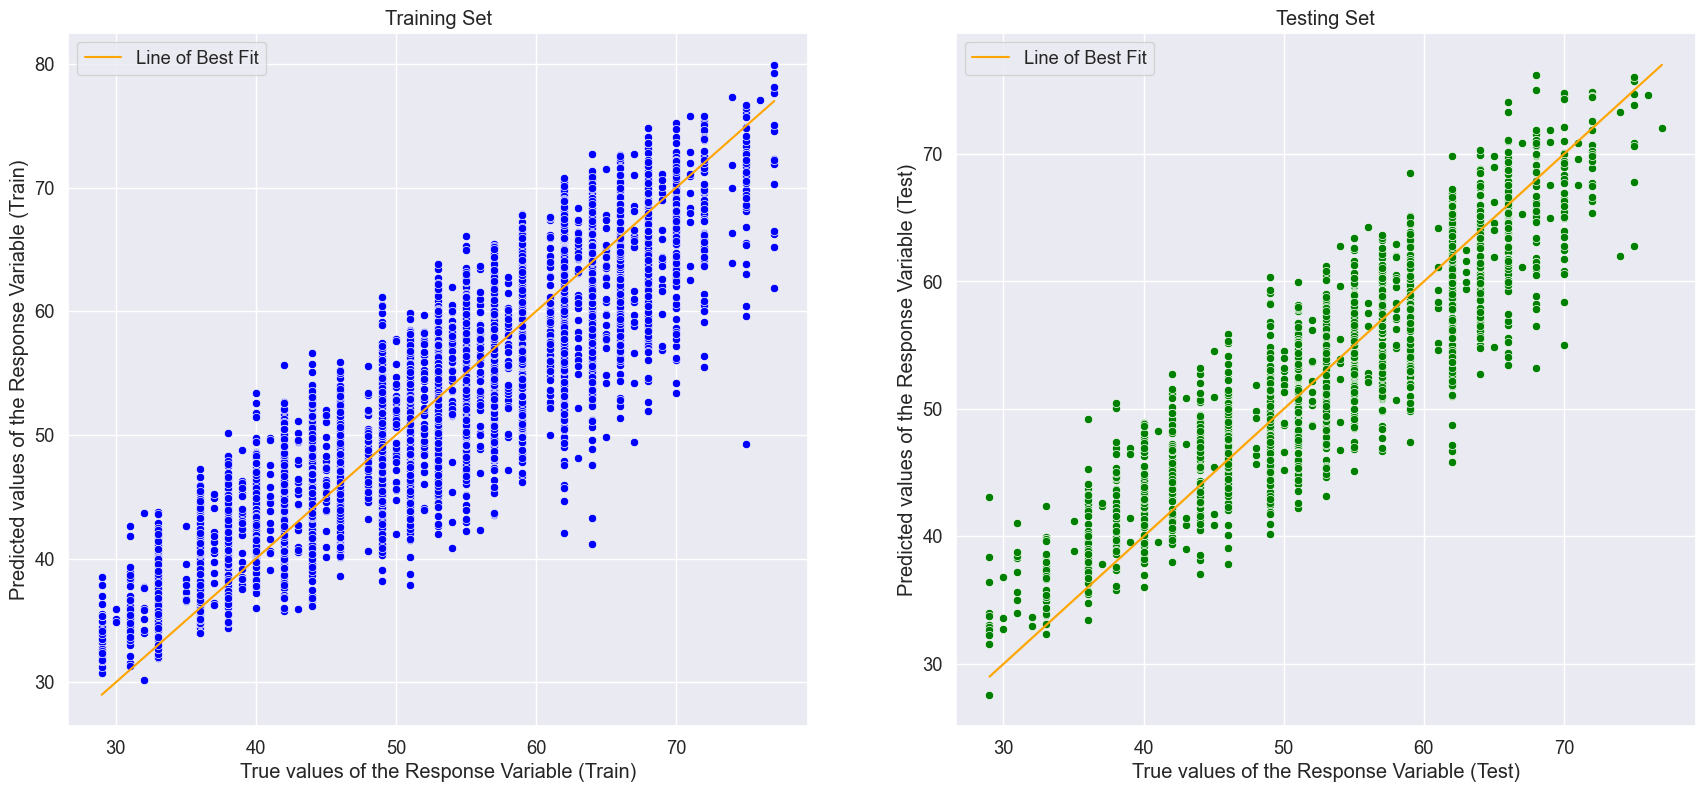

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.796390479337715
Mean Squared Error (MSE) 	: 19.243235586808154

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.7997943329669257
Mean Squared Error (MSE) 	: 18.197669516531153



0.7997943329669257

In [72]:
dataset_final = dataset_cleaned1.copy()

# Store the mean and standard deviation
final_mean = {}
final_std = {}

for col in exponents:
    dataset_final[col] = pow(dataset_final[col], exponents[col])
    final_mean[col] = dataset_final[col].mean()
    final_std[col] = dataset_final[col].std()
    dataset_final[col] = [(v-final_mean[col])/final_std[col] for v in dataset_final[col]]

linear_reg(dataset_final, plot=True)

Applying our obtained exponent values, renormalising and performing linear regression provides us with a significantly improved model:

The distribution of values are visibly more linear than our previous regression, suggesting that the features are more accurately represented with the exponents applied. However, the logistic regression appears to be poor in predicting `grades_max` in the range of 30-40, with most data points falling above the optimal line. Additionally, the model appears prone to underestimating `grades_max` values in the intermediate range as well.

These parameters are reused for subsequent SVM and KNN models.

### Alternative Models

In particular, we explore 2 models and compare their resuts: Support Vector Machine (SVM) and K-Nearest Neighbours (KNN)

#### SVM

We use the Linear SVM model (which does not utilise the kernel trick) as it is suitable for larger datasets with fewer features.

Explained Variance (R^2) for SVM 	: 0.814606211274132
Mean Squared Error (MSE) for SVM 	: 18.045884676438508


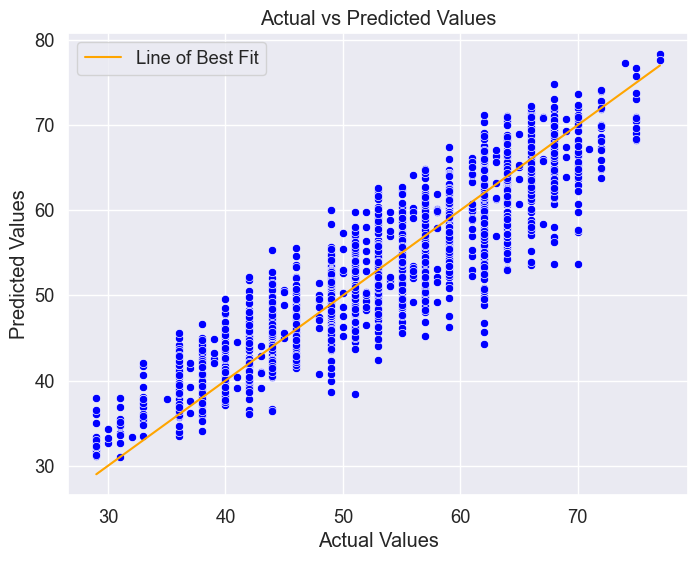

In [67]:
# Train SVM on dataset

predictors = dataset_final.drop(columns=["grades_max"])
response = pd.DataFrame(dataset_final["grades_max"])

predictors_train, predictors_test, response_train, response_test = train_test_split(predictors, response, test_size = 0.2, random_state = 69)

model_svm = svm.LinearSVR(max_iter=100000)
model_svm.fit(predictors_train, response_train["grades_max"])

y_pred = model_svm.predict(predictors_test)
r2 = r2_score(response_test, y_pred)
mse = mean_squared_error(response_test, y_pred)
print("Explained Variance (R^2) for SVM \t:", r2)
print("Mean Squared Error (MSE) for SVM \t:", mse)

# Plot actual vs predicted values
plt.figure(figsize=(8,6))
sb.scatterplot(x=response_test['grades_max'], y=y_pred.flatten(), color='blue', marker='o')
sb.lineplot(x=response_test['grades_max'], y=response_test['grades_max'], color='orange', label='Line of Best Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

The R^2 and MSE values of our model have noticeably improved from our logistic regression. Notably, the model appears to outperform logistic regression in the midrange values for `grades_max`

#### KNN

We also train the K-Nearest Neighbours model on the dataset and compare its results:

Best value of n_neighbors: 20
Explained Variance (R^2) for KNN 	: 0.8185249610008253
Mean Squared Error (MSE) for KNN 	: 17.664440906775344


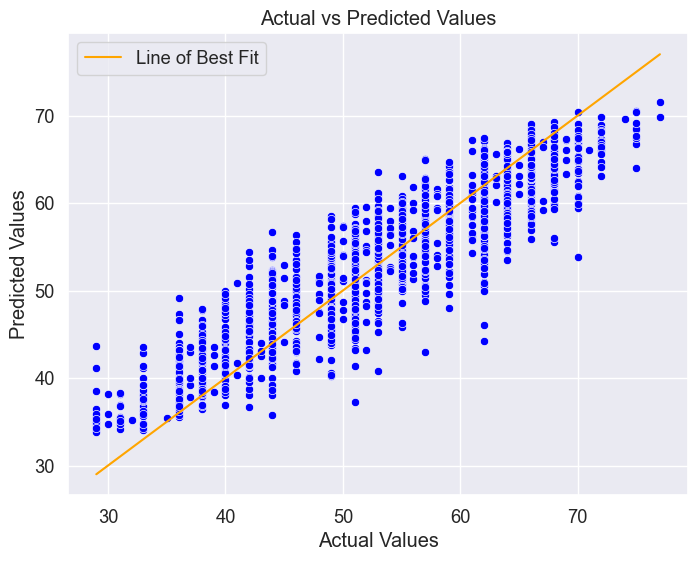

In [89]:
# Instantiate KNN regressor
knn_r = KNeighborsRegressor()

# Perform grid search to find optimal value of n_neighbors
gcv = GridSearchCV(knn_r, {'n_neighbors':[2,5,10,20,30,40,50,60,70,100]}).fit(predictors_train, response_train)
print("Best value of n_neighbors:", gcv.best_params_['n_neighbors'])

# Train KNN model with optimal n_neighbors value
model_knn = KNeighborsRegressor(gcv.best_params_['n_neighbors']).fit(predictors_train, response_train)

# Evaluate performance of KNN model
y_pred = model_knn.predict(predictors_test)
r2 = r2_score(response_test, y_pred)
mse = mean_squared_error(response_test, y_pred)
print("Explained Variance (R^2) for KNN \t:", r2)
print("Mean Squared Error (MSE) for KNN \t:", mse)

# Plot actual vs predicted values
plt.figure(figsize=(8,6))
sb.scatterplot(x=response_test['grades_max'], y=y_pred.flatten(), color='blue', marker='o')
sb.lineplot(x=response_test['grades_max'], y=response_test['grades_max'], color='orange', label='Line of Best Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

KNN gives us the best R^2 and MSE values among the three models trained, suggesting that it is the most accurate model. 

However, we can visibly observe that the model appears to be poor at predicting low and high values of `max_grade`. This is due to KNN relying on neighbouring data points to predict values. Extreme values of `max_grade` likely correspond to outlier data that are sparse by nature, and taking an average of nearby values probably results in a prediction that skews towards the mean, as represented by the scatterplot.

To conclude, the accuracy indicators obtained suggest that KNN is the best at accurately predicting `max_grade` for centered datapoints (data that lie within the quartile ranges).

## Conclusion

To summarise our findings from the previous section:
1. Linear Regression provided us with suitable transformations for our variables
2. SVM was more accurate than Logistic Regression
3. KNN was the most accurate model for standard datapoints but fails to accurately predict extreme datapoints

We suggest that the best model could be a hybrid of SVM and KNN:
1. SVM is the most accurate model for extreme datapoints, therefore we apply it first to identify those points
2. The KNN model is then applied to the remaining datapoints to provide a more accurate prediction for those datapoints

Upper Bound: 62.0 Lower Bound: 46.0
Explained Variance (R^2) for KNN 	: 0.826269756358754
Mean Squared Error (MSE) for KNN 	: 16.91057701072834


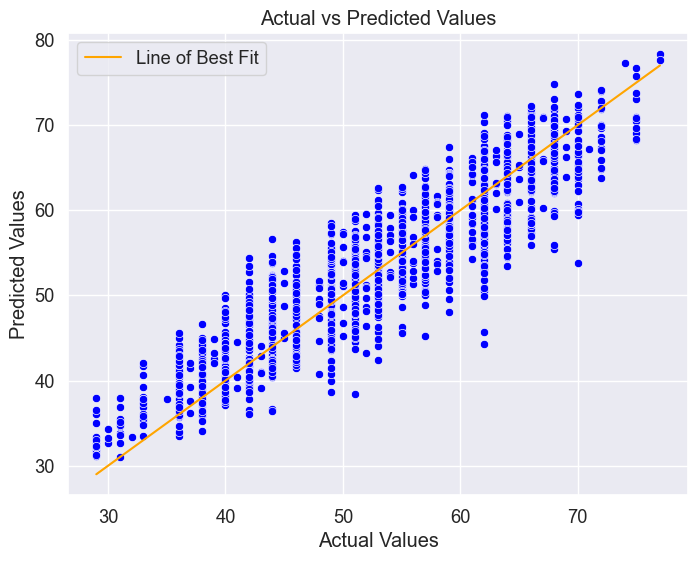

In [95]:
# Hybrid SVM and KNN model
def hybrid_pred(dataset):
    upper_bound = dataset_final["grades_max"].quantile(0.75)
    lower_bound = dataset_final["grades_max"].quantile(0.25)
    print("Upper Bound:", upper_bound, "Lower Bound:", lower_bound)
    
    y_pred = pd.Series([0] * len(dataset), index=dataset.index)
    svm_pred = model_svm.predict(dataset)
    quantile_range = (svm_pred <= upper_bound) & (svm_pred >= lower_bound)
    y_pred[~quantile_range] = svm_pred[~quantile_range]
    
    knn_pred = model_knn.predict(dataset[quantile_range])
    y_pred[quantile_range] = knn_pred.flatten()
    
    return y_pred
    
# Evaluate performance of hybrid model
y_pred = hybrid_pred(predictors_test)
r2 = r2_score(response_test, y_pred)
mse = mean_squared_error(response_test, y_pred)
print("Explained Variance (R^2) for KNN \t:", r2)
print("Mean Squared Error (MSE) for KNN \t:", mse)

# Plot actual vs predicted values
plt.figure(figsize=(8,6))
sb.scatterplot(x=response_test['grades_max'], y=y_pred, color='blue', marker='o')
sb.lineplot(x=response_test['grades_max'], y=response_test['grades_max'], color='orange', label='Line of Best Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

We observe that this is the most accurate model for our dataset, and conclude our machine learning segment.

## Limitations

We can explain the remaining variance in our final model in several ways:
1. It is unclear when the biometric data of each individual is taken. Young climbers may increase in height over time, and inactive climbers may gain weight, which could explain the low correlations between `grades_max` and biometrics.
2. `days_diff` and `grades_count` only guarantee training duration and frequency, but do not guarantee intensity. Climbers who actively challenge themselves to more difficult climbs might outperform their peers which would not be reflected by our current metrics.
3. Our dataset concerns outdoor climbers, and may not consider the frequency of indoor trainings that might influence the future performance of a climber.
4. In our outlier removal step, we observed a discrepancy in reporting of `age` and `years_cl` which was addressed by filtering out individuals who had infeasibly low starting ages (<=3 years old), but this may not have removed all erroneous data. This is likely, considering the skew in `start_age` which is a variable one would expect a normal distribution on.

Additionally, it is surprising that KNN outperforms SVM when predicting values within the main range of data. This project demonstrates the feasibility and relevance of basic models even with the introduction of newer models like SVM and neural networks.